<a href="https://colab.research.google.com/github/RicoStaedeli/PhantomDrawerResearch/blob/main/generate_image_modelshoot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Mount Google Drive
This section is to import all the different libraries for the sections bellow.

First import all nececessary libraries

Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

# Collecting Data
In this section the synthetic images are generated.
To generate the images i use the diffusor model: SG161222/Realistic_Vision_V1.4


## Setup

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In [ ]:
!nvidia-smi

Sun Oct 15 11:45:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q transformers==4.31.0
!pip install -q accelerate==0.21.0
!pip install -q diffusers==0.20.0
!pip install -q huggingface_hub==0.16.4
!pip install -q omegaconf==2.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import diffusers
import transformers

import sys
import os
import shutil
import time

import torch
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

if torch.cuda.is_available():
    device_name = torch.device("cuda")
    torch_dtype = torch.float16
else:
    device_name = torch.device("cpu")
    torch_dtype = torch.float32

In [ ]:
#unrealRalism_V40
#!wget https://civitai.com/api/download/models/165237 --content-disposition

In [ ]:
#load converter script -safetensor to torch
#!wget https://raw.githubusercontent.com/huggingface/diffusers/v0.20.0/scripts/convert_original_stable_diffusion_to_diffusers.py


In [ ]:
#convert safetensor file
#!python convert_original_stable_diffusion_to_diffusers.py --checkpoint_path /content/drive/MyDrive/DS_Project/epicrealism_naturalSinRC1VAE.safetensors --dump_path /content/drive/MyDrive/DS_Project/epicrealism_naturalSinRC1VAE/ --from_safetensors

In [ ]:
# Follows community convention.
# Clip skip = 1 uses the all text encoder layers.
# Clip skip = 2 skips the last text encoder layer.

clip_skip = 1

if clip_skip > 1:
    text_encoder = transformers.CLIPTextModel.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        subfolder = "text_encoder",
        num_hidden_layers = 12 - (clip_skip - 1),
        torch_dtype = torch_dtype
    )

In [ ]:
# Load the pipeline.

model_path = "wavymulder/modelshoot"

if clip_skip > 1:
    # TODO clean this up with the condition below.
    pipe = diffusers.DiffusionPipeline.from_pretrained(
        model_path,
        torch_dtype = torch_dtype,
        safety_checker = None,
        text_encoder = text_encoder,
    )
else:
    pipe = diffusers.DiffusionPipeline.from_pretrained(
        model_path,
        torch_dtype = torch_dtype,
        safety_checker = None
    )

pipe = pipe.to(device_name)

# Change the pipe scheduler to EADS.
pipe.scheduler = diffusers.EulerAncestralDiscreteScheduler.from_config(
    pipe.scheduler.config
)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
# Prompt embeddings to overcome CLIP 77 token limit.
# https://github.com/huggingface/diffusers/issues/2136

def get_prompt_embeddings(
    pipe,
    prompt,
    negative_prompt,
    split_character = ",",
    device = torch.device("cpu")
):
    max_length = pipe.tokenizer.model_max_length
    # Simple method of checking if the prompt is longer than the negative
    # prompt - split the input strings using `split_character`.
    count_prompt = len(prompt.split(split_character))
    count_negative_prompt = len(negative_prompt.split(split_character))

    # If prompt is longer than negative prompt.
    if count_prompt >= count_negative_prompt:
        input_ids = pipe.tokenizer(
            prompt, return_tensors = "pt", truncation = False
        ).input_ids.to(device)
        shape_max_length = input_ids.shape[-1]
        negative_ids = pipe.tokenizer(
            negative_prompt,
            truncation = False,
            padding = "max_length",
            max_length = shape_max_length,
            return_tensors = "pt"
        ).input_ids.to(device)

    # If negative prompt is longer than prompt.
    else:
        negative_ids = pipe.tokenizer(
            negative_prompt, return_tensors = "pt", truncation = False
        ).input_ids.to(device)
        shape_max_length = negative_ids.shape[-1]
        input_ids = pipe.tokenizer(
            prompt,
            return_tensors = "pt",
            truncation = False,
            padding = "max_length",
            max_length = shape_max_length
        ).input_ids.to(device)

    # Concatenate the individual prompt embeddings.
    concat_embeds = []
    neg_embeds = []
    for i in range(0, shape_max_length, max_length):
        concat_embeds.append(
            pipe.text_encoder(input_ids[:, i: i + max_length])[0]
        )
        neg_embeds.append(
            pipe.text_encoder(negative_ids[:, i: i + max_length])[0]
        )

    return torch.cat(concat_embeds, dim = 1), torch.cat(neg_embeds, dim = 1)

Generate Prompts fort testing

In [ ]:
prompts = []
prompts.append("""A man who looks like John Cena. He is wearing a blue jeans and a white shirt.""")
prompts.append("""A man who looks like John Cena. He is wearing a blue jeans and a white shirt and glasses.""")
prompts.append("""A man who looks like John Cena. He is wearing a blue jeans and a white shirt and a red cap.""")

negative_prompt = """bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal """
normal_prompts = []
embedded_prompts = []
for prompt in prompts:
  prompt_embeds, negative_prompt_embeds = get_prompt_embeddings(
      pipe,
      prompt,
      negative_prompt,
      split_character = ",",
      device = device_name
  )
  normal_prompts.append([prompt,negative_prompt])
  embedded_prompts.append([prompt_embeds,negative_prompt_embeds])


In [ ]:
# Set to True to use prompt embeddings, and False to
# use the prompt strings.
use_prompt_embeddings = True

# Seed and batch size.
start_idx = 0
batch_size = 2
seeds = [i for i in range(start_idx , start_idx + batch_size, 1)]

# Number of inference steps.
num_inference_steps = 50

# Guidance scale.
guidance_scale = 15

# Image dimensions - limited to GPU memory.
width  = 768
height = 512


In [ ]:
images = []
#GENERATE SAMPLES WITH STRING PROMPT
for prompt,negative_prompt in normal_prompts:
  for count, seed in enumerate(seeds):
      print(f'Prompt: {prompt} Negative Prompt: {negative_prompt}')
      start_time = time.time()
      new_img = pipe(
          prompt = prompt,
          negative_prompt = negative_prompt,
          width = width,
          height = height,
          guidance_scale = guidance_scale,
          num_inference_steps = num_inference_steps,
          num_images_per_prompt = 1,
          #generator = torch.manual_seed(seed),
      ).images

      images = images + new_img

Prompt: A man who looks like John Cena. He is wearing a blue jeans and a white shirt. Negative Prompt: bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal 


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: A man who looks like John Cena. He is wearing a blue jeans and a white shirt. Negative Prompt: bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal 


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: A man who looks like John Cena. He is wearing a blue jeans and a white shirt and glasses. Negative Prompt: bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal 


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: A man who looks like John Cena. He is wearing a blue jeans and a white shirt and glasses. Negative Prompt: bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal 


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: A man who looks like John Cena. He is wearing a blue jeans and a white shirt and a red cap. Negative Prompt: bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal 


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: A man who looks like John Cena. He is wearing a blue jeans and a white shirt and a red cap. Negative Prompt: bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal 


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

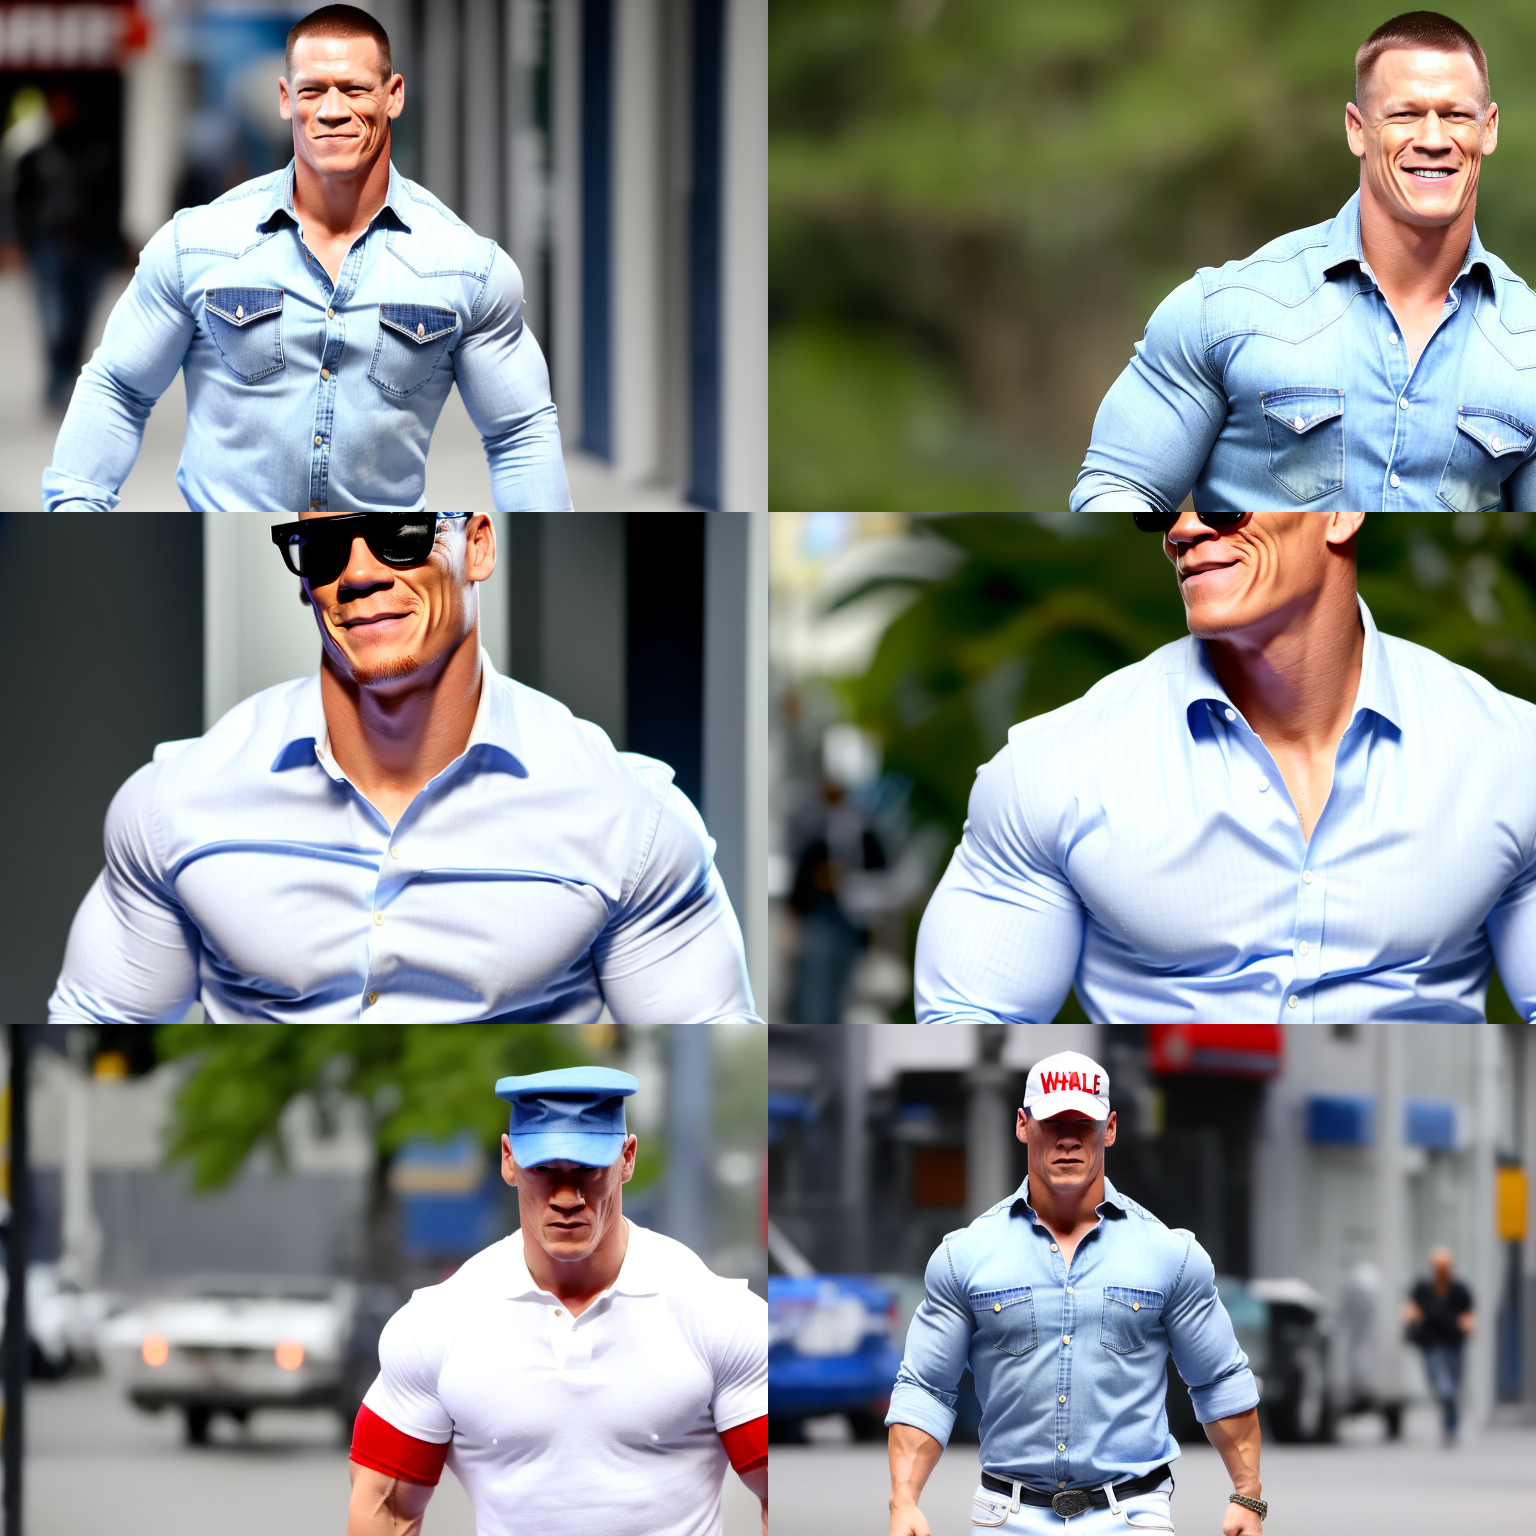

In [ ]:
grid = image_grid(images, rows=3, cols=2)
grid

In [ ]:
images_prompted = []
#generate samples with embedded prompts
for prompt_embeds,negative_prompt_embeds in embedded_prompts:
  for count, seed in enumerate(seeds):
      print(f'Prompt: {prompt} Negative Prompt: {negative_prompt}')
      new_img = pipe(
          prompt_embeds = prompt_embeds,
          negative_prompt_embeds = negative_prompt_embeds,
          width = width,
          height = height,
          guidance_scale = guidance_scale,
          num_inference_steps = num_inference_steps,
          num_images_per_prompt = 1,
          generator = torch.manual_seed(seed),
      ).images
      images_prompted = images_prompted + new_img

Prompt: A man who looks like John Cena. He is wearing a blue jeans and a white shirt and a red cap. Negative Prompt: bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal 


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: A man who looks like John Cena. He is wearing a blue jeans and a white shirt and a red cap. Negative Prompt: bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal 


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: A man who looks like John Cena. He is wearing a blue jeans and a white shirt and a red cap. Negative Prompt: bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal 


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: A man who looks like John Cena. He is wearing a blue jeans and a white shirt and a red cap. Negative Prompt: bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal 


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: A man who looks like John Cena. He is wearing a blue jeans and a white shirt and a red cap. Negative Prompt: bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal 


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt: A man who looks like John Cena. He is wearing a blue jeans and a white shirt and a red cap. Negative Prompt: bad anatomy, fused fingers, deformed, weird, bad resolution, weird, worst quality, worst resolution,
too blurry, not relevant,unreal 


  0%|          | 0/50 [00:00<?, ?it/s]

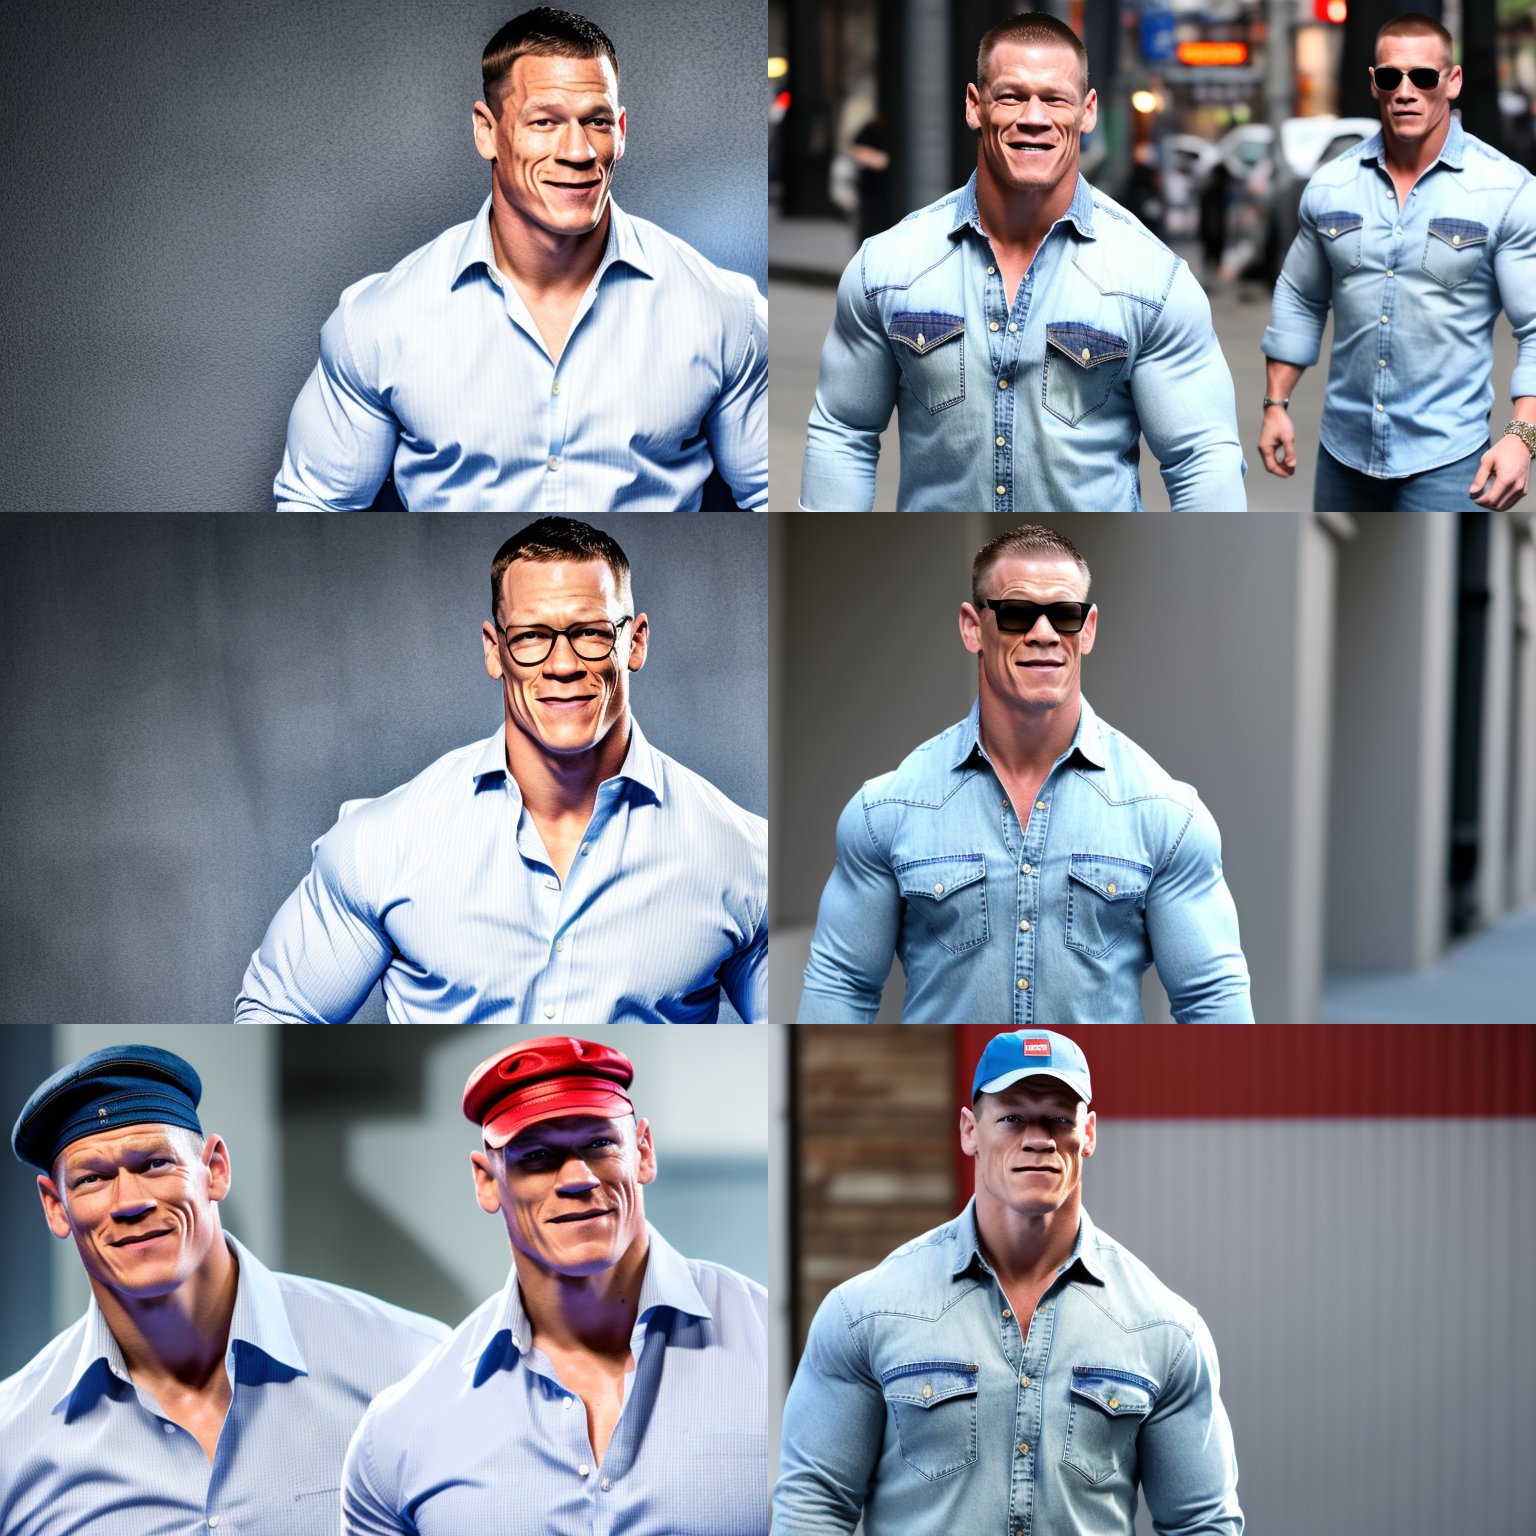

In [ ]:
grid = image_grid(images_prompted, rows=3, cols=2)
grid